# DogFaceNet version 10: Stable version


## Imports and constants

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf

import os
import numpy as np
import skimage as sk
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import tensorflow.keras.backend as K
from triplets_processing import *

In [2]:
PATH = '../data/dogfacenet/aligned/after_2/'
PATH_SAVE = '../output/history/'
PATH_MODEL = '../output/model/'
SIZE = (104,104,3)
VALID_SPLIT = 0.1
TEST_SPLIT = 0.1

## Data pre-processing
- Load image and labels
- Load .npy files create with linux and adapt them for windows
- Normalize the images
- Split into training set and testing set (open-set)

In [3]:
filenames = np.empty(0)
labels = np.empty(0)
idx = 0
for root,dirs,files in os.walk(PATH):
    if len(files)>1:
        for i in range(len(files)):
            files[i] = root + '/' + files[i]
        filenames = np.append(filenames,files)
        labels = np.append(labels,np.ones(len(files))*idx)
        idx += 1
print(len(labels))
h,w,c = SIZE
images = np.empty((len(filenames),h,w,c))
for i,f in enumerate(filenames):
    images[i] = sk.io.imread(f)

3148


In [4]:
labels = np.load('labels.npy')
filenames = np.load('filenames.npy')
h,w,c = SIZE
images = np.empty((len(filenames),h,w,c))
for i,f in enumerate(filenames):
    idxБ = f.find('Б')
    if idxБ>=0:
        f = f[:idxБ] + "ü" + f[idxБ+1:]
    idxmarley = f.find('marley-groсman')
    if idxmarley>=0:
        f = f[:idxmarley] + "marley-großman" + f[idxmarley+len("marley-großman"):]
    images[i] = sk.io.imread(f)

In [5]:
# Normalization
images /= 255.0


In [6]:
nbof_classes = len(np.unique(labels))
print(nbof_classes)

485


Data splitting

In [8]:
nbof_test = int(TEST_SPLIT*nbof_classes)

keep_test = np.less(labels,nbof_test)
keep_train = np.logical_not(keep_test)

images_test = images[keep_test]
labels_test = labels[keep_test]

images_train = images[keep_train]
labels_train = labels[keep_train]

## Model definition

### Loss definition

In [10]:
alpha = 0.3
def triplet(y_true,y_pred):
    
    a = y_pred[0::3]
    p = y_pred[1::3]
    n = y_pred[2::3]
    
    ap = K.sum(K.square(a-p),-1)
    an = K.sum(K.square(a-n),-1)

    return K.sum(tf.nn.relu(ap - an + alpha))

### Metric definition

In [11]:
def triplet_acc(y_true,y_pred):
    a = y_pred[0::3]
    p = y_pred[1::3]
    n = y_pred[2::3]
    
    ap = K.sum(K.square(a-p),-1)
    an = K.sum(K.square(a-n),-1)
    
    return K.less(ap+alpha,an)

### Network definition

This the current stable version of used model, run the following block if you want to retrain the network from scratch, if not, you have to run the next block.

In [11]:
# dogfacenet_v12
emb_size = 32

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Add, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda, BatchNormalization

inputs = Input(shape=(104, 104, 3))

x = Conv2D(16, (7, 7), use_bias=False, activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)

for layer in [16,32,64,128,512]:

    x = Conv2D(layer, (3, 3), strides=(2,2), use_bias=False, activation='relu', padding='same')(x)
    r = BatchNormalization()(x)
    r = Dropout(0.25)(r)
    
    x = Conv2D(layer, (3, 3), use_bias=False, activation='relu', padding='same')(r)
    x = BatchNormalization()(x)
    r = Add()([r,x])
    r = Dropout(0.25)(r)
    
    x = Conv2D(layer, (3, 3), use_bias=False, activation='relu', padding='same')(r)
    x = BatchNormalization()(x)
    x = Add()([r,x])
    x = Dropout(0.25)(x)
    

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(emb_size, use_bias=False)(x)
outputs = Lambda(lambda x: tf.nn.l2_normalize(x,axis=-1))(x)

model = tf.keras.Model(inputs,outputs)

model.compile(loss=triplet,
              optimizer='adam',
              metrics=[triplet_acc])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 104, 104, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 104, 104, 16) 2352        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 104, 104, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 52, 52, 16)   2304        batch_normalization[0][0]        
__________________________________________________________________________________________________
batch_norm

Run the following if you want to load a pre-trained model.

In [12]:
#model = tf.keras.models.load_model(PATH_MODEL + '2019.02.28.dogfacenet_v12.hard_triplet.alpha.0.3.2.h5', custom_objects={'triplet':triplet,'triplet_acc':triplet_acc})

In [12]:
#model = tf.keras.models.load_model(PATH_MODEL + '2019.02.27.dogfacenet_v11.hard_triplet_trained.data_aug_2.16.h5', custom_objects={'triplet':triplet,'triplet_acc':triplet_acc})

## Training

Every n=3 epochs will be generated a new set of hard triplets. During training the learning is going to be reduce to foster convergence:

- 14*3 epochs with lr=0.001
- 4*3 epochs with lr=0.0005
- 4*3 epochs with lr=0.0003
- 4*1 epochs with lr=0.0001

The model will be saved after every points above (so 4 times in total). The convergence histories are stored in "histories" list and will be saved at the end of the training

In [ ]:
histories = []

In [ ]:
epochs = [14,4,4,4]
lr = [0.001,0.0005,0.0003,0.0001]
for l in range(1,len(lr)):
    model.compile(loss=triplet,
              optimizer=tf.keras.optimizers.Adam(lr[l]),
              metrics=[triplet_acc])
    for k in range(epochs[l]):
        epoch_nb = k+sum(epochs[:l])
        print("Beginning epoch number: "+str(epoch_nb)+", over "+str(sum(epochs))+" epochs. \n")
        
        new_images_train, new_labels_train = shuffle_classes(images_train,labels_train)
        predict_train=model.predict(new_images_train)
        triplet_train, y_triplet_train = define_hard_triplets(new_images_train,new_labels_train,predict_train)

        for i in range(3):
            history = model.fit(
                triplet_train,
                y_triplet_train,
                batch_size = 21*3,
                epochs = 1,
                validation_data=(triplet_test,y_triplet_test),
                shuffle=False
            )
            histories += [history]

    model.save(PATH_MODEL + '2019.03.02.dogfacenet_v24.hard_triplet.alpha.0.3.'+str(l)+'.h5')

loss = np.empty(0)
val_loss = np.empty(0)
acc = np.empty(0)
val_acc = np.empty(0)

for history in histories:
    loss = np.append(loss,history.history['loss'])
    val_loss = np.append(val_loss,history.history['val_loss'])
    acc = np.append(acc,history.history['triplet_acc'])
    val_acc = np.append(val_acc,history.history['val_triplet_acc'])

    
history_ = np.array([loss,val_loss,acc,val_acc])
np.save(PATH_SAVE+'2018.03.02.dogfacenet_v24.hard_triplet.data_aug.0.a_0.3.npy',history_)
np.savetxt(PATH_SAVE+'2018.03.02.dogfacenet_v24.hard_triplet.data_aug.0.a_0.3.txt',history_)

If you want to load an existing history file, run the following two blocks.

In [12]:
history_ = np.load(PATH_SAVE+'2018.02.28.dogfacenet_v12.hard_triplet.data_aug.5.a_0.3.npy')

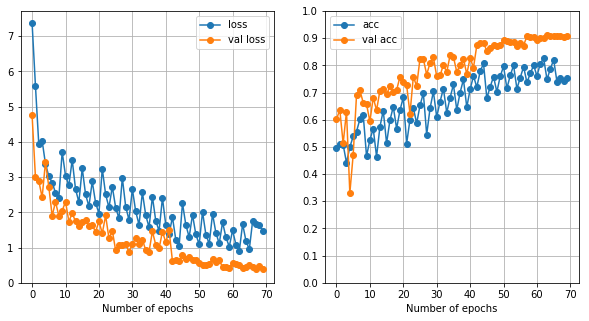

In [15]:
loss,val_loss,acc,val_acc = history_

epochs = np.arange(len(loss))
fig = plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(epochs,loss, '-o', label="loss")
plt.plot(epochs,val_loss, '-o', label="val loss")
plt.xlabel("Number of epochs")
plt.yticks(np.arange(0,8,1))
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs,acc, '-o', label="acc")
plt.plot(epochs,val_acc, '-o', label="val acc")
plt.xlabel("Number of epochs")
plt.yticks(np.arange(0,1.1,0.1))
plt.grid()
plt.legend()

## Evaluation

### Face verification

In [13]:
NBOF_PAIRS = 5000
#NBOF_PAIRS = len(images_test)

# Create pairs
h,w,c = SIZE
pairs = np.empty((NBOF_PAIRS*2,h,w,c))
issame = np.empty(NBOF_PAIRS)
class_test = np.unique(labels_test)
for i in range(NBOF_PAIRS):
    alea = np.random.rand()
    # Pair of different dogs
    if alea < 0.5:
        # Chose the classes:
        class1 = np.random.randint(len(class_test))
        class2 = np.random.randint(len(class_test))
        while class1==class2:
            class2 = np.random.randint(len(class_test))
            
        # Extract images of this class:
        images_class1 = images_test[np.equal(labels_test,class1)]
        images_class2 = images_test[np.equal(labels_test,class2)]
        
        # Chose an image amoung these selected images
        pairs[i*2] = images_class1[np.random.randint(len(images_class1))]
        pairs[i*2+1] = images_class2[np.random.randint(len(images_class2))]
        issame[i] = 0
    # Pair of same dogs
    else:
        # Chose a class
        clas = np.random.randint(len(class_test))
        images_class = images_test[np.equal(labels_test,clas)]
        
        # Select two images from this class
        idx_image1 = np.random.randint(len(images_class))
        idx_image2 = np.random.randint(len(images_class))
        while idx_image1 == idx_image2:
            idx_image2 = np.random.randint(len(images_class))
        
        pairs[i*2] = images_class[idx_image1]
        pairs[i*2+1] = images_class[idx_image2]
        issame[i] = 1

In [ ]:
# Test: Check the pairs
s = 10
n = 5
print(issame[s:(n+s)])
fig = plt.figure(figsize=(5,3*n))
for i in range(s,s+n):
    plt.subplot(n,2,2*(i-s)+1)
    plt.imshow(pairs[2*i]*0.5+0.5)
    plt.subplot(n,2,2*(i-s)+2)
    plt.imshow(pairs[2*i+1]*0.5+0.5)

In [14]:
predict=model.predict(pairs)
# Separates the pairs
emb1 = predict[0::2]
emb2 = predict[1::2]

# Computes distance between pairs
diff = np.square(emb1-emb2)
dist = np.sum(diff,1)


best = 0
best_t = 0
thresholds = np.arange(0.001,4,0.001)
for i in tqdm_notebook(range(len(thresholds))):
    less = np.less(dist, thresholds[i])
    acc = np.logical_not(np.logical_xor(less, issame))
    acc = acc.astype(float)
    out = np.sum(acc)
    out = out/len(acc)
    if out > best:
        best_t = thresholds[i]
        best = out

print("Best threshold: " + str(best_t))
print("Best accuracy: " + str(best))

HBox(children=(IntProgress(value=0, max=3999), HTML(value='')))


Best threshold: 0.986
Best accuracy: 0.918


In [15]:
# False accepted examples and False rejected examples
t = 0.68
fa = []
fr = []
for i in range(len(dist)):
    # false accepted
    if issame[i] == 0 and dist[i]<t:
        fa += [i]
    if issame[i] == 1 and dist[i]>t:
        fr += [i]

[0. 1. 0. 1. 0.]


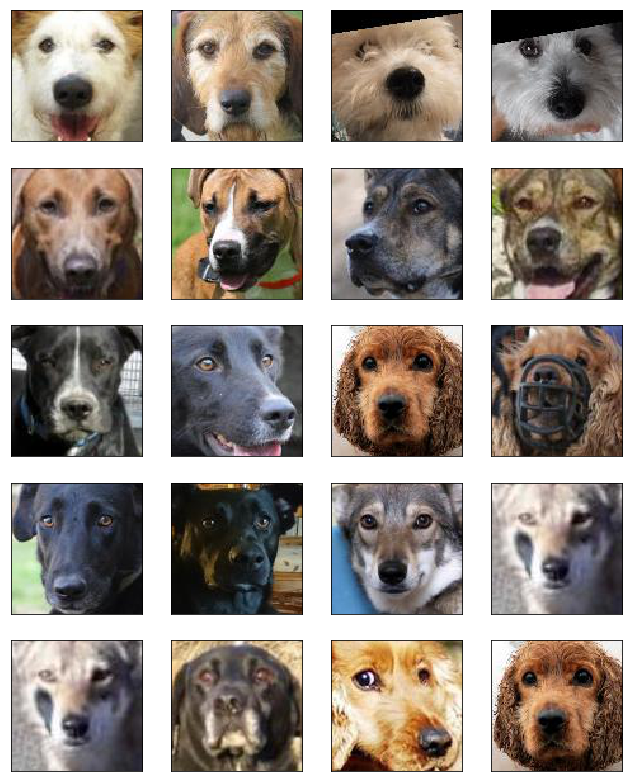

In [33]:
# Test: Look at wrong pairs
s = 10
sr = 20
n = 5
print(issame[s:(n+s)])
fig = plt.figure(figsize=(11,2.8*n))
for i in range(s,s+n):
    # False accepted
    plt.subplot(n,4,4*(i-s)+1)
    plt.imshow(pairs[2*fa[i+s]])
    plt.xticks([])
    plt.yticks([])
    plt.subplot(n,4,4*(i-s)+2)
    plt.imshow(pairs[2*fa[i+s]+1])
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(n,4,4*(i-s)+3)
    plt.imshow(pairs[2*fr[i+sr]])
    plt.xticks([])
    plt.yticks([])
    plt.subplot(n,4,4*(i-s)+4)
    plt.imshow(pairs[2*fr[i+sr]+1])
    plt.xticks([])
    plt.yticks([])

In [16]:
len(fa)

318

In [17]:
len(fr)

102

In [15]:
threshold = 0.3
less = np.less(dist, threshold)
acc = np.logical_not(np.logical_xor(less, issame))
acc = acc.astype(float)
out = np.sum(acc)
out = out/len(acc)

print("Accuracy: " + str(out))

NameError: name 'dist' is not defined

### ROC curve visualization

In [19]:
mod = tf.keras.Model(model.layers[0].input, model.layers[-1].output)
predict=mod.predict(pairs)
# Separates the pairs
emb1 = predict[0::2]
emb2 = predict[1::2]

# Computes distance between pairs
diff = np.square(emb1-emb2)
dist = np.sum(diff,1)

# Computes the ROC depending on different thresholds

thresholds = np.arange(0.001,4,0.001)
tprs = np.empty(len(thresholds))
fprs = np.empty(len(thresholds))

p = np.sum(issame.astype(float))
n = np.sum(np.logical_not(issame).astype(float))

for i in tqdm_notebook(range(len(thresholds))):
    logical_pred = np.less(dist, thresholds[i])
    tp = np.sum(np.logical_and(logical_pred,issame).astype(float))
    fp = np.sum(np.logical_and(logical_pred,np.logical_not(issame)).astype(float))
    tprs[i] = tp/p
    fprs[i] = fp/n
    

HBox(children=(IntProgress(value=0, max=3999), HTML(value='')))

In [16]:
np.save('roc_dogfacenet_v11.npy', [tprs, fprs])

In [21]:
tprs2,fprs2 = np.load('roc_dogfacenet_v12.npy')

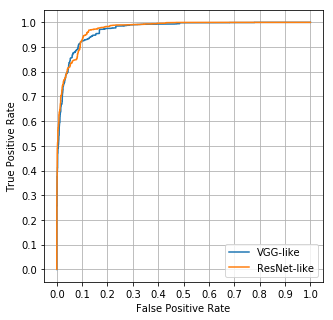

In [29]:
plt.figure(figsize=(5,5))
plt.plot(fprs,tprs,label="VGG-like")
plt.plot(fprs2,tprs2,label="ResNet-like")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xticks(np.arange(0,1.1,0.1))
plt.yticks(np.arange(0,1.1,0.1))
plt.grid()
plt.legend()
#plt.title("ROC curve")

### Face recognition: K-NN
m is the number of images that are going to be selected for k-NN "training".

In [16]:
from sklearn.neighbors import KNeighborsClassifier

In [17]:
count_im_c = np.zeros(len(np.unique(labels_test)))
for i in range(len(labels_test)):
    count_im_c[int(labels_test[i])] += 1
print("Number of images per classes:")
count_im_c

Number of images per classes:


array([ 6.,  4.,  3.,  8.,  3.,  6.,  5.,  5.,  3.,  5.,  5.,  4.,  8.,
        5.,  6.,  5., 23.,  6., 16.,  5.,  6.,  5.,  6.,  7.,  5.,  5.,
        5.,  3.,  9.,  6.,  5.,  8.,  4.,  2.,  5.,  8.,  3.,  5.,  8.,
        2.,  8.,  6.,  3.,  5., 19.,  5.,  4., 10.])

In [23]:
for m in range(1,5):
    
    # First we drop the classes with less than m images per class:
    to_drop = []
    for i in range(len(count_im_c)):
        if count_im_c[i] <= m:
            to_drop += [i]
    new_labels_test = np.copy(labels_test)
    new_images_test = np.copy(images_test)
    for i in range(len(to_drop)):
        idx_to_drop = np.arange(len(new_labels_test))[np.equal(to_drop[i],new_labels_test)]
        new_labels_test=np.delete(new_labels_test, idx_to_drop, 0)
        new_images_test=np.delete(new_images_test, idx_to_drop, 0)
    np.unique(new_labels_test)
    
    # Model prediction on the reduce dataset
    new_pred_test = model.predict(new_images_test)

    nbof_test = 1000
    mean_acc = 0
    mini = 1
    maxi = 0
    
    # Definition of K
    if m == 1:
        K = 1
    else:
        K = m+1

    for _ in tqdm_notebook(range(nbof_test)):
        # I select m images per classes for k-NN training
        nbof_kimages=m*len(np.unique(new_labels_test))
        kpred=np.empty((nbof_kimages,new_pred_test.shape[-1]))
        y_kimages = np.empty(nbof_kimages, dtype=int)
        y_kuniques = np.unique(new_labels_test)
        for i in range(len(y_kuniques)):
            for j in range(m):
                y_kimages[i*m+j] = y_kuniques[i]

        others_pred = np.copy(new_pred_test)
        y_others = np.copy(new_labels_test)

        for i in range(len(y_kuniques)):
            keep_classes_images = np.arange(len(y_others))[np.equal(y_kimages[i*m],y_others)]
            choices = np.empty(0,dtype=int)

            if len(keep_classes_images) <= m:
                print("Bug!")
                break

            for j in range(m):
                choice = np.random.randint(len(keep_classes_images))
                while choice in choices:
                    choice = np.random.randint(len(keep_classes_images))
                choices=np.append(choices,choice)
            #print(choices)
            for j in range(m):
                kpred[i*m+j] = others_pred[keep_classes_images[choices[j]]]

            others_pred = np.delete(others_pred,keep_classes_images[choices],0)
            y_others = np.delete(y_others,keep_classes_images[choices],0)

        neigh = KNeighborsClassifier(n_neighbors=K, weights='distance')
        neigh.fit(kpred, y_kimages)
        acc = np.sum(np.equal(y_others,neigh.predict(others_pred)))/len(y_others)

        if mini > acc:
            mini = acc
        if maxi < acc:
            maxi = acc

        mean_acc += acc
    mean_acc /= nbof_test
    print("Mean accuracy: " + str(mean_acc))
    print("Maximum accuracy: " + str(maxi))
    print("Minimum accuracy: " + str(mini))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Mean accuracy: 0.5693280000000006
Maximum accuracy: 0.676
Minimum accuracy: 0.464


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Mean accuracy: 0.6136633663366335
Maximum accuracy: 0.7326732673267327
Minimum accuracy: 0.5148514851485149


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Mean accuracy: 0.6440512820512829
Maximum accuracy: 0.7371794871794872
Minimum accuracy: 0.5448717948717948


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Mean accuracy: 0.6445431034482741
Maximum accuracy: 0.75
Minimum accuracy: 0.5086206896551724


### Face clustering

In [54]:
from sklearn.cluster import KMeans

In [ ]:
mod = tf.keras.Model(model.layers[0].input, model.layers[-1].output)
predict=mod.predict(images_test)

In [53]:
predict=model.predict(images_test)

In [55]:
kmeans = KMeans(n_clusters=len(np.unique(labels_test)),max_iter=2000, random_state=0,tol=0.2).fit(predict)

In [56]:
images_cluster = [images_test[np.equal(kmeans.labels_,i)] for i in range(len(labels_test))]
labels_cluster = [labels_test[np.equal(kmeans.labels_,i)] for i in range(len(labels_test))]

[34. 44. 44. 44. 44. 44.]


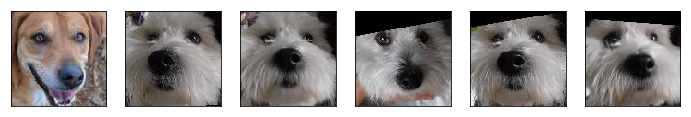

[1. 3. 5.]


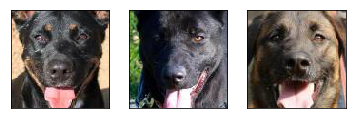

[17. 18. 18. 18. 18. 47. 47. 47.]


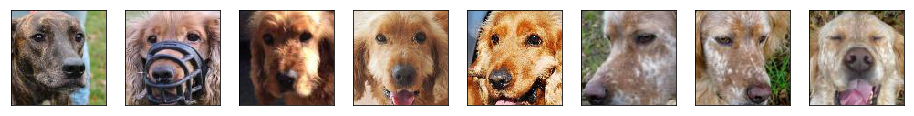

[35. 35. 36.]


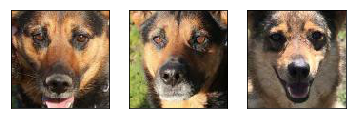

[30. 30. 30. 31.]


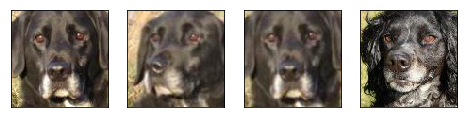

[21. 21. 21. 21. 21.]


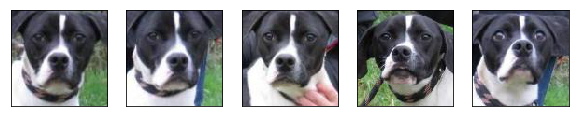

[ 5. 18. 18. 29. 29. 29. 29.]


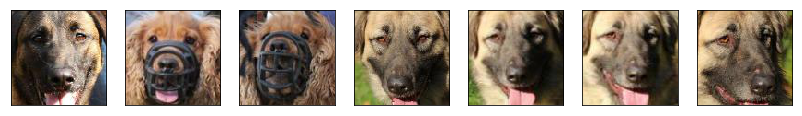

[6. 6. 6. 6. 6.]


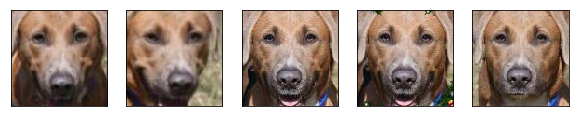

[ 0. 22. 22. 22. 22. 34. 38. 39. 39.]


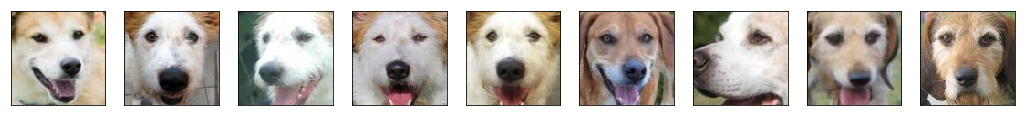

[15. 15. 15. 15. 15.]


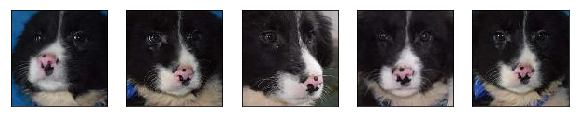

[16. 16. 16.]


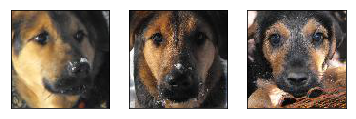

[ 1. 13. 13. 13. 13. 16.]


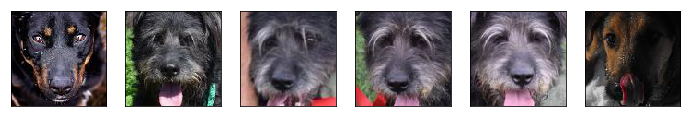

[11. 31. 31. 43. 43. 43. 43.]


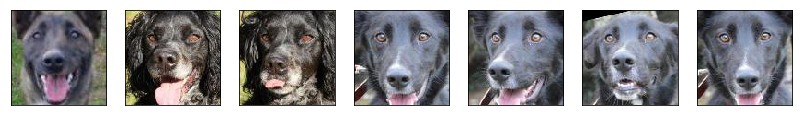

[14. 14. 14. 14. 14. 14. 23.]


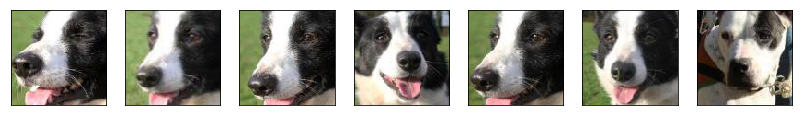

[20. 20. 20. 20. 20. 20.]


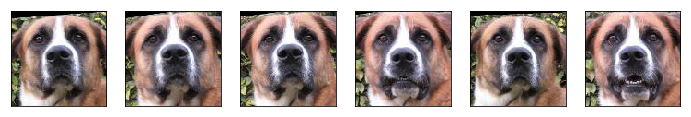

[3. 7. 7. 7. 7. 7.]


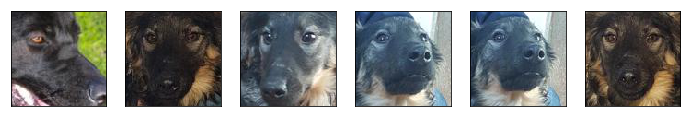

[16. 16. 16. 16. 16. 16. 16.]


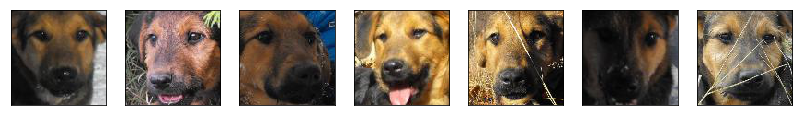

[19. 27. 27. 30. 30.]


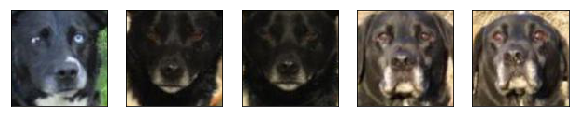

[28. 28. 28. 28. 28. 28. 28. 28. 28. 32. 36.]


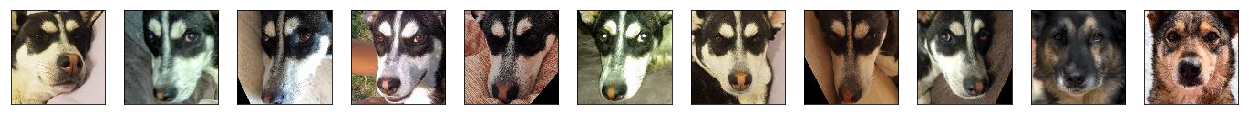

[23. 23. 23. 23. 23.]


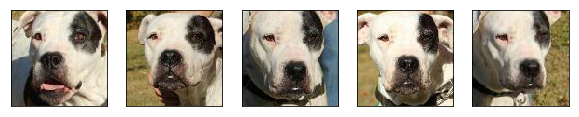

[ 4. 18. 38. 38. 38. 38. 38. 38. 38. 40. 47. 47.]


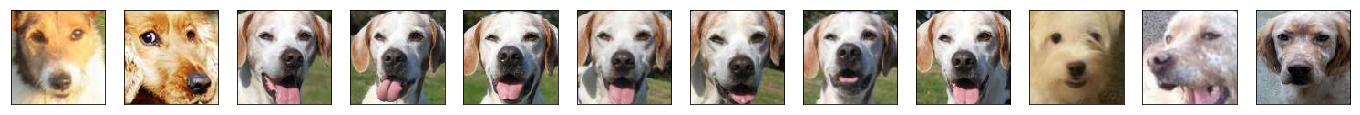

[29. 29. 42. 42. 42.]


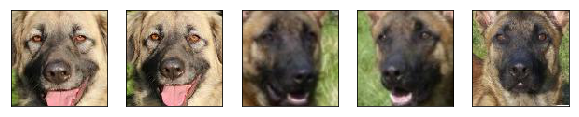

[ 1.  1. 10. 10. 10. 10. 18.]


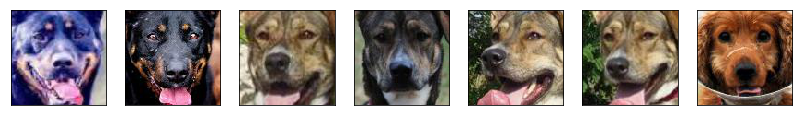

[ 0.  0.  4.  4. 18. 18. 22. 22. 23. 34. 34. 34. 40. 40. 40. 40. 40. 40.
 40. 44. 47. 47. 47.]


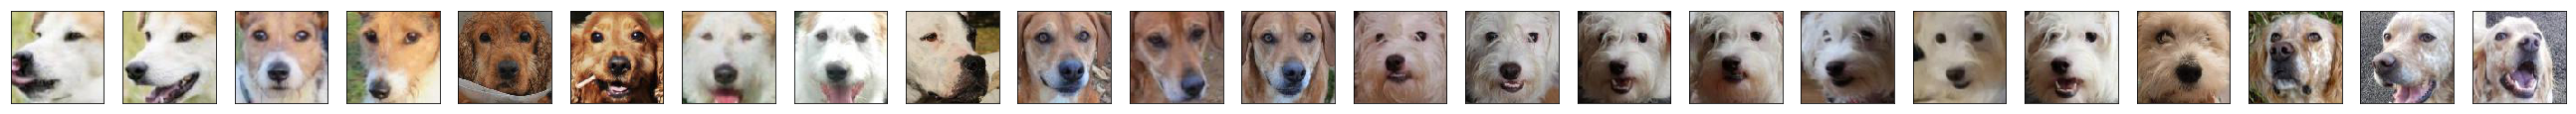

[12. 12. 12. 12. 12. 12. 12.]


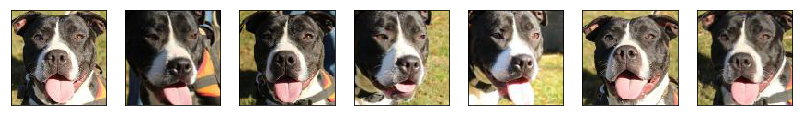

[41. 41. 41. 41. 41. 41.]


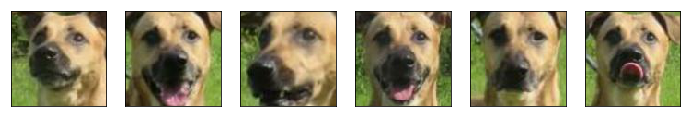

[44. 44. 44. 44. 44.]


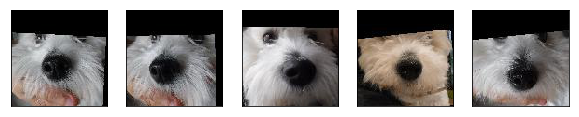

[3. 3. 3. 3. 3.]


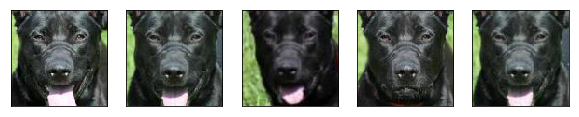

[35.]


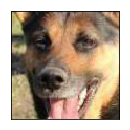

[24. 24. 24. 24. 24.]


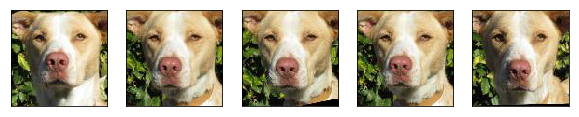

[43. 45. 45. 45. 45. 45.]


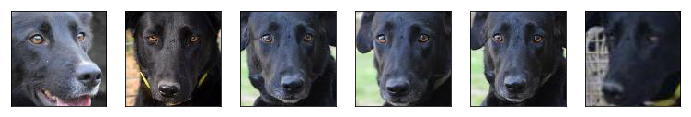

[16. 16. 16. 16. 46. 46. 46.]


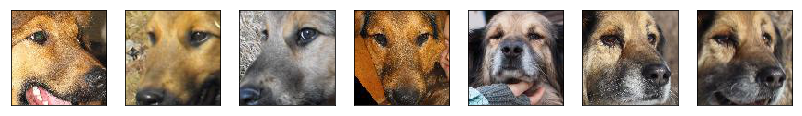

[26. 26. 26. 26. 26.]


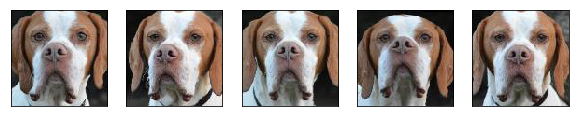

[19. 19. 19. 19. 27. 31.]


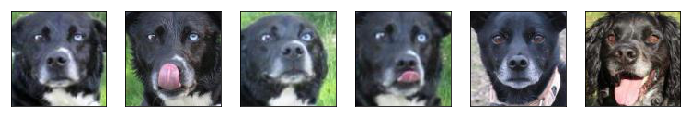

[ 2. 16. 18. 18. 18. 25. 25. 25. 47.]


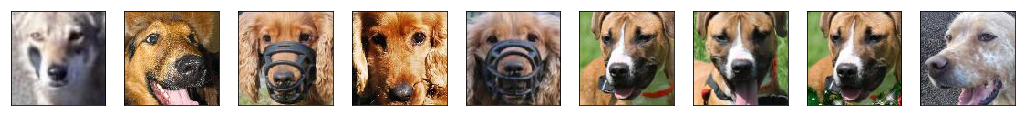

[ 0.  0.  0. 44. 44. 44. 44. 44. 44. 44. 44.]


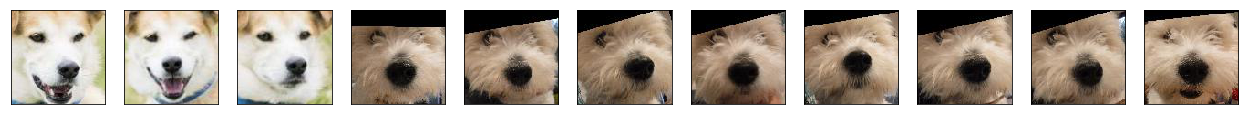

[37. 37. 37. 37. 37.]


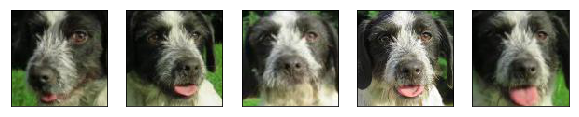

[ 8.  8.  8. 18. 46.]


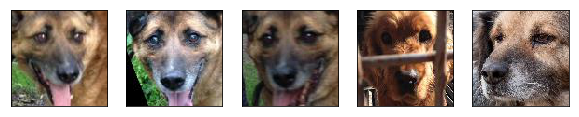

[25. 25. 47.]


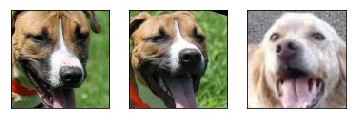

[17. 17. 17. 17. 18. 18.]


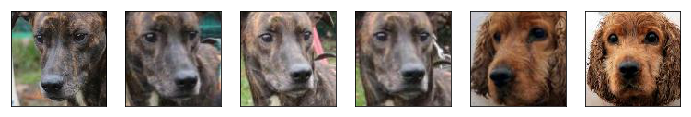

[ 3. 11. 17.]


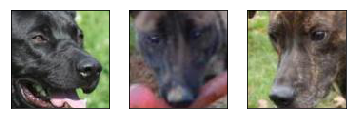

[16. 16.]


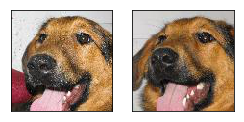

[ 5.  5.  5.  5. 11. 11.]


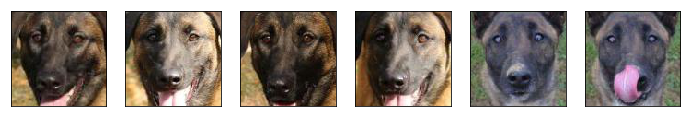

[10. 13. 16. 33. 33.]


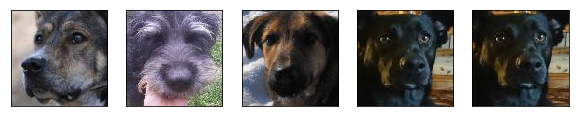

[32. 32. 32. 35. 35. 35. 35. 35.]


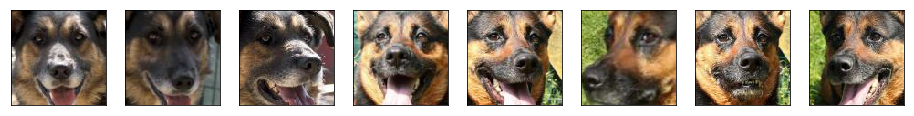

[ 2.  2. 36.]


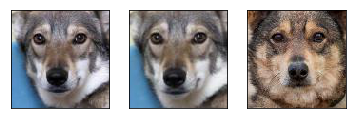

[16. 16. 16. 16.]


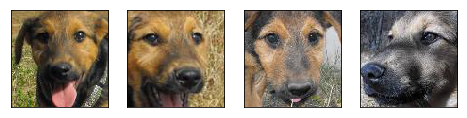

[ 9.  9.  9.  9.  9. 12. 31. 31. 31. 31.]


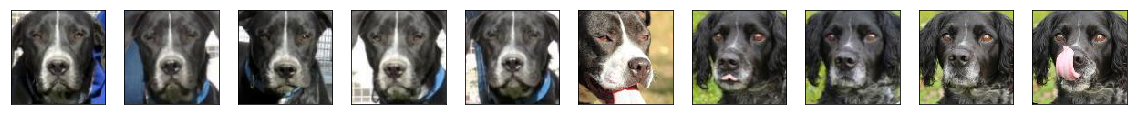

In [50]:
for i in range(len(images_cluster)):
    length = len(images_cluster[i])
    if length > 0:
        print(labels_cluster[i])
        fig=plt.figure(figsize=(length*2,2))
        for j in range(length):
            plt.subplot(1,length,j+1)
            plt.imshow(images_cluster[i][j])
            plt.xticks([])
            plt.yticks([])
        plt.show()
        #fig.savefig('D:/CREATIONS/PAPERS/DogFaceNet/clustering/dfn12.clustering.'+str(i)+'.png')

## Observation on the heatmap

In order to see what the network actually looks at into pictures, the following series of block can optionally be run.

In [ ]:
model.layers

In [ ]:
mod3 = tf.keras.Model(model.layers[0].input, model.layers[9].output)
predict3 = mod3.predict(images_train[0:100:10])

plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(10,10,i*10+1)
    sk.io.imshow(images_train[i*10])
    
    for j in range(9):
        pred3 = np.mean(predict3[i][:,:,j*25:j*25+3],axis=-1)
        plt.subplot(10,10,i*10+2+j)
        sk.io.imshow(images_train[i*10])
        plt.imshow(pred3,cmap='plasma')

In [ ]:
s = 100
mod1 = tf.keras.Model(model.layers[0].input, model.layers[1].output)
predict1 = mod1.predict(images_train[0+s:100+s:10])

mod2 = tf.keras.Model(model.layers[0].input, model.layers[9].output)
predict2 = mod2.predict(images_train[0+s:100+s:10])

mod3 = tf.keras.Model(model.layers[0].input, model.layers[14].output)
predict3 = mod3.predict(images_train[0+s:100+s:10])

plt.figure(figsize=(9,20))
for i in range(10):
    pred1 = np.mean(predict1[i],axis=-1)
    pred2 = np.mean(predict2[i],axis=-1)
    pred3 = np.mean(predict3[i],axis=-1)

    
    plt.subplot(10,4,i*4+1)
    sk.io.imshow(images_train[i*10 + s])
    plt.subplot(10,4,i*4+2)
    plt.imshow(pred1,cmap='plasma')
    plt.subplot(10,4,i*4+3)
    plt.imshow(pred2,cmap='plasma')
    plt.subplot(10,4,i*4+4)
    plt.imshow(pred3,cmap='plasma')

In [ ]:
history = model.fit_generator(
    train_datagen.flow(images_train,labels_train,batch_size = 64),
    epochs = 12,
    validation_data=(images_valid,labels_valid)
)

In [ ]:
model.save('../output/model/dogfacenet_v6_cosine.h5')